In [1]:
from neural_net.count_mse_loss import CountMSELoss
from neural_net.ensemble_model import EnsembleModel
from neural_net.temporal_conv_net import TCNPushUpCounter

In [2]:

def create_ensemble_from_results(fold_results, input_channels=6):
    """Create an EnsembleModel and load weights from training results.

    Args:
        fold_results: List of FoldResult from training
        input_channels: Number of input channels for TCNPushUpCounter

    Returns:
        EnsembleModel with loaded weights
    """
    models = [TCNPushUpCounter(input_channels=input_channels) for _ in range(len(fold_results))]

    state_dicts = [fold.model_state_dict for fold in fold_results]

    ensemble = EnsembleModel.from_pretrained_models(models, state_dicts)

    return ensemble

In [3]:
import torch
import torch.optim as optim
from neural_net.ensemble_trainer import EnsembleTrainer
from feature_engineering.transforms import Compose, RandomScaling, RandomNoise, RandomTimeWarp, RandomSequenceReverse, \
    RandomSequenceRepeat, RandomHorizontalFlipLandmarks, RandomDropout


def train_model():
    trainer = EnsembleTrainer(
        model_factory=lambda: TCNPushUpCounter(),
        loss_fn=CountMSELoss(),
        optimizer_factory=lambda parameters : optim.AdamW(parameters),
        patience=100,
        max_epochs=1000
    )

    return trainer.train(
        video_data_dir="video-data",
        train_transform=Compose([
            RandomSequenceRepeat(),
            RandomSequenceReverse(),
            RandomHorizontalFlipLandmarks(),
            RandomTimeWarp(p=0.8),
            RandomScaling(),
            RandomNoise(p=1.0),
            RandomDropout()
        ])
    )

In [4]:

# setting a manual seed for reproducibility
torch.manual_seed(100)

training_results = train_model()
model = create_ensemble_from_results(training_results, input_channels=6)
print(f"Created ensemble with {len(model)} models")

Training on device: cpu

Note that the first epoch of the first fold will take a long time to train
as pose detection is run on every video (takes up to 30 minutes).

Subsequent epochs will be much faster as pose detection is cached.



Training Folds:   0%|          | 0/5 [00:00<?, ?fold/s]

Fold 1/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 1 complete in 15.88 seconds | Best epoch: 41 | Val Loss: 0.6547, MAE: 2.85, Exact: 0.0%, Off1: 0.0%


Fold 2/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 2 complete in 14.16 seconds | Best epoch: 33 | Val Loss: 1.7460, MAE: 3.09, Exact: 0.0%, Off1: 0.0%


Fold 3/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 3 complete in 14 seconds | Best epoch: 31 | Val Loss: 0.3609, MAE: 2.45, Exact: 0.0%, Off1: 0.0%


Fold 4/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 4 complete in 13.24 seconds | Best epoch: 23 | Val Loss: 2.9162, MAE: 3.14, Exact: 0.0%, Off1: 6.7%


Fold 5/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 5 complete in 13.50 seconds | Best epoch: 26 | Val Loss: 0.6951, MAE: 2.65, Exact: 0.0%, Off1: 0.0%

Training Complete
Total time: 1 minute and 10.86 seconds
Average time per fold: 14.16 seconds
Created ensemble with 5 models


# Evaluation

## TODO 6

Include any code which you feel is useful for evaluating your model performance below.

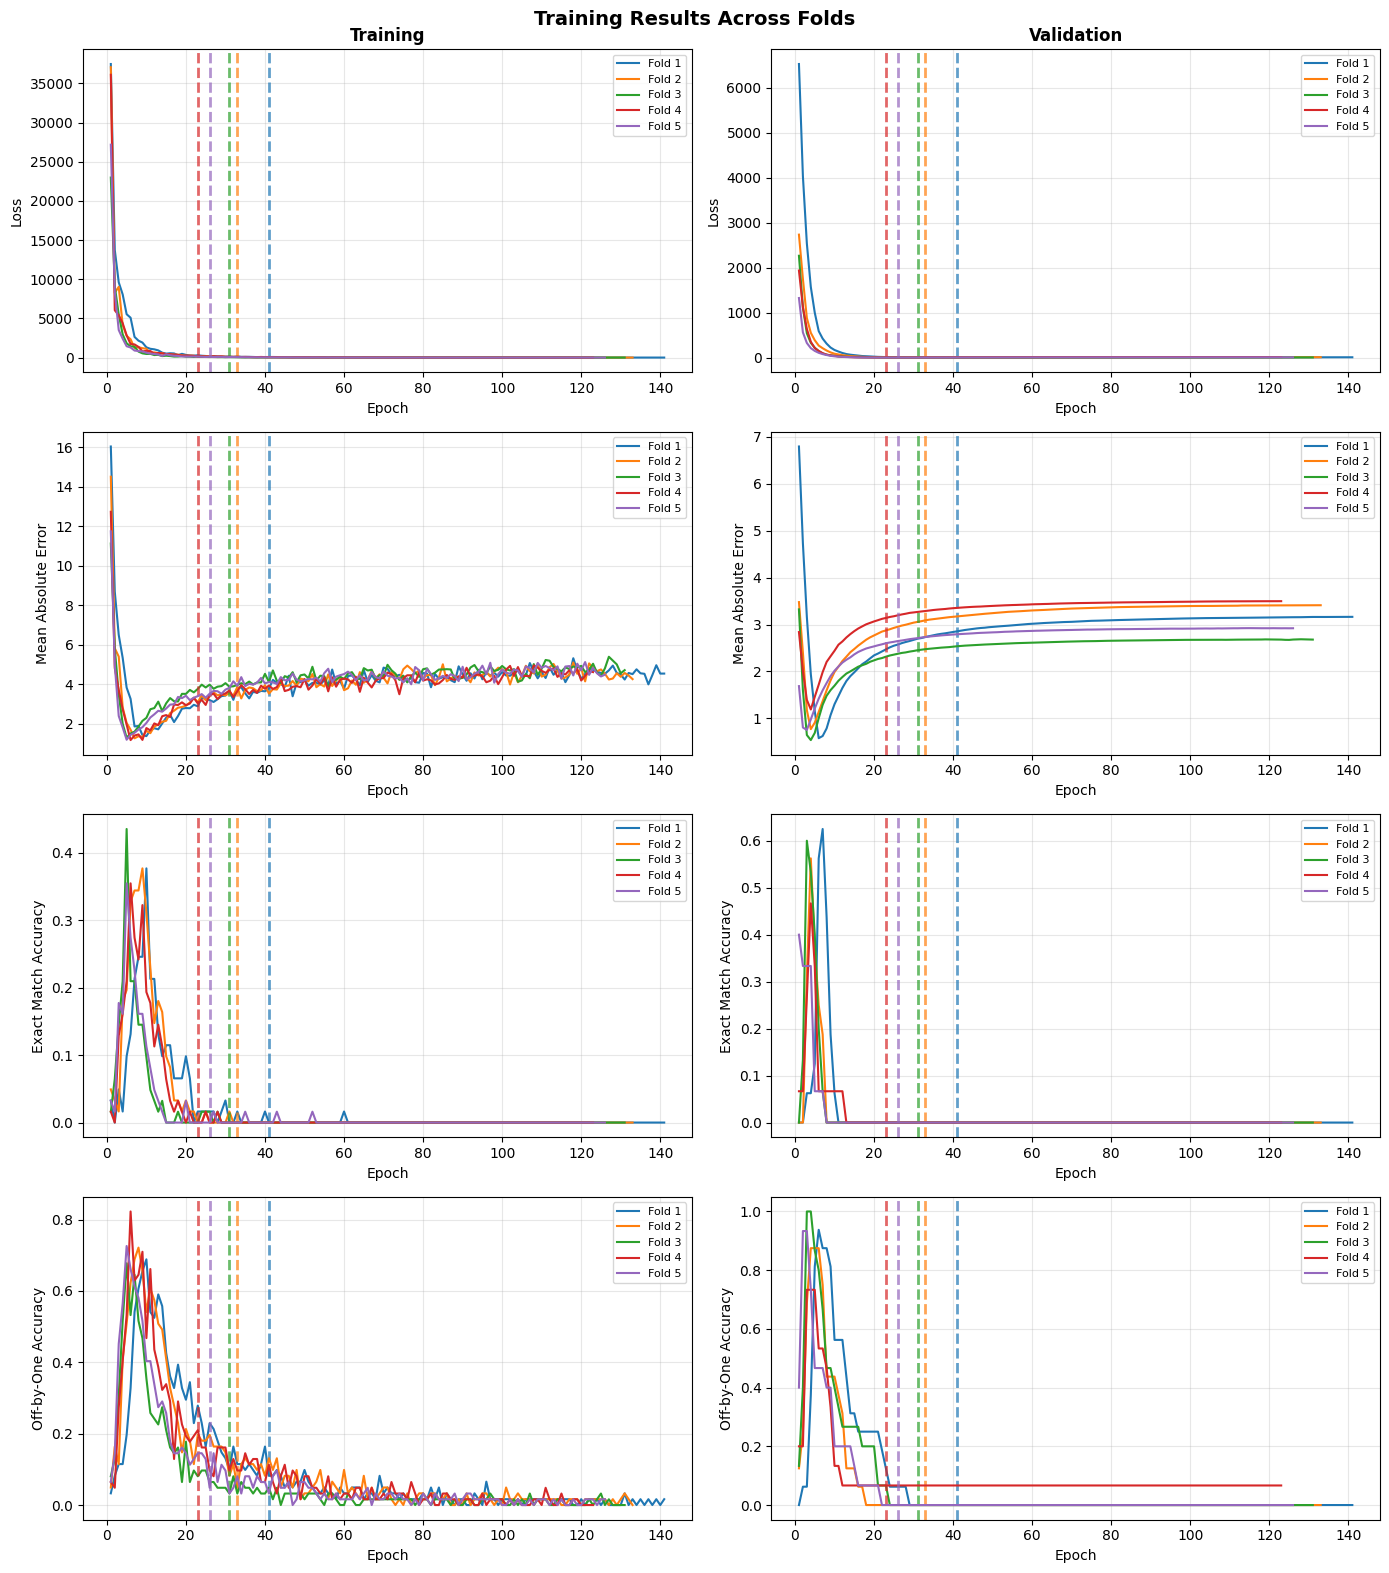

Training results saved to 'plots/training_results.png'


In [5]:
from evaluation.training_plots import plot_training_results

plot_training_results(training_results)

## Ensemble Evaluation

Evaluate the ensemble model on the full training dataset.

In [6]:
import pandas as pd
from evaluation.ensemble_evaluation import (
    evaluate_ensemble_on_dataset,
    plot_density_maps,
    plot_predicted_vs_true,
    plot_wrong_predictions_density_maps,
)

evaluation_results = evaluate_ensemble_on_dataset(model, "video-data")

metrics_df = pd.DataFrame({
    'Metric': [
        'Mean Absolute Error',
        'Exact Match Accuracy',
        'Off-by-One Accuracy'
    ],
    'Value': [
        f"{evaluation_results['mae']:.4f}",
        f"{evaluation_results['exact_match_accuracy']:.2%}",
        f"{evaluation_results['off_by_one_accuracy']:.2%}"
    ]
})

print()
print("Ensemble Evaluation Results on Training Set")
metrics_df.style.hide(axis='index')


Ensemble Evaluation Results on Training Set


Metric,Value
Mean Absolute Error,2.8415
Exact Match Accuracy,0.00%
Off-by-One Accuracy,1.30%


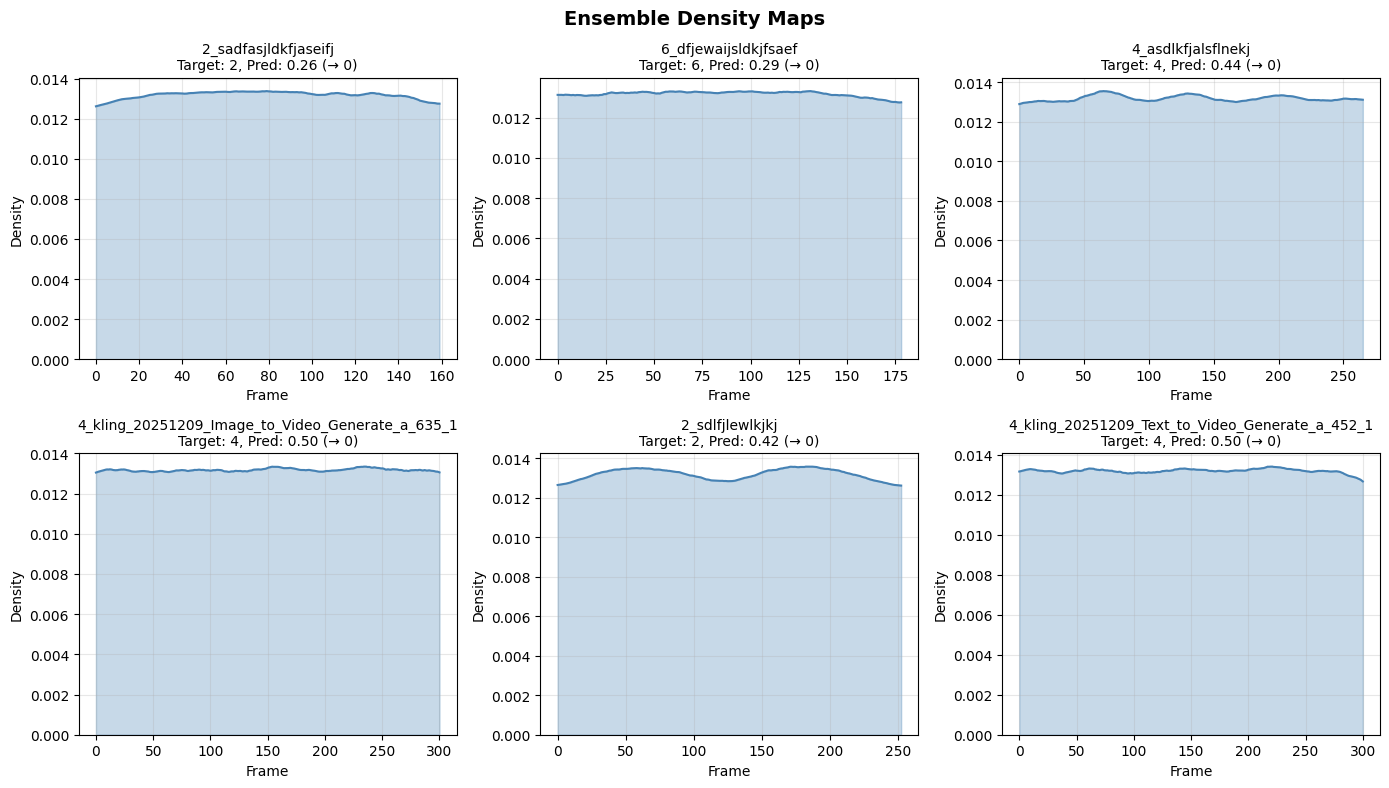

Density maps saved to 'plots/ensemble_density_maps.png'


In [7]:
plot_density_maps(evaluation_results, num_samples=6)

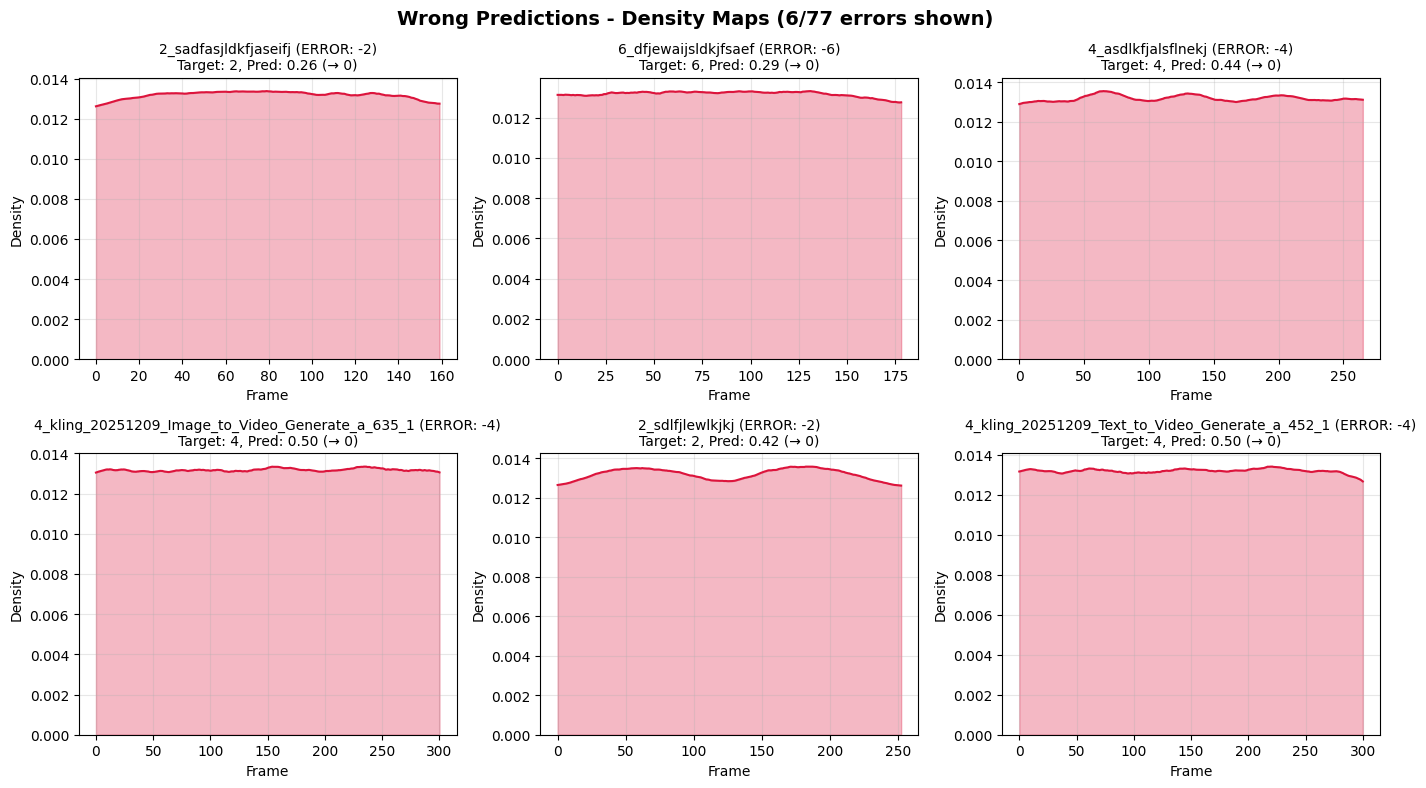

Wrong predictions density maps saved to 'plots/wrong_predictions_density_maps.png'
Total wrong predictions: 77 out of 77 samples (100.0%)


In [8]:
plot_wrong_predictions_density_maps(evaluation_results, num_samples=6)

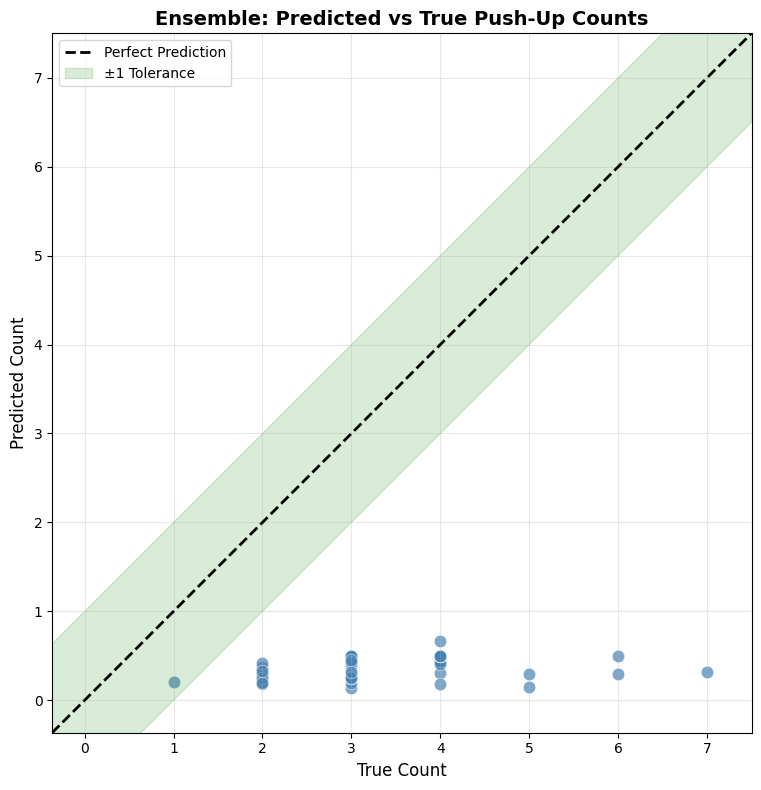

Plot saved to 'plots/predicted_vs_true.png'


In [9]:
plot_predicted_vs_true(evaluation_results)